In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
if not os.path.exists('./TL_dataset'):
    patoolib.extract_archive('TL_dataset.zip')

In [64]:
# Extracting the dataset and creating the train and test folders
data_dir = pathlib.Path('TL_dataset')
classes = os.listdir(data_dir)
print('classes: ',classes)

# Creating the train and validation folders
if not os.path.exists('./splited_dataset'):
    os.makedirs('./splited_dataset/train')
    os.makedirs('./splited_dataset/val')

    # Creating the class folders in train and validation folders
    for i in classes:
        os.makedirs('./splited_dataset/train/' + i)
        os.makedirs('./splited_dataset/val/' + i)

random.seed(0)
# Splitting the dataset into train and test sets
for i in classes:
    src = "./TL_dataset/" + i # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)*0.8)])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, "./splited_dataset/train/" + i)
    for name in val_FileNames:
        shutil.copy(name, "./splited_dataset/val/" + i)

classes:  ['1', '2', '3']
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9


In [65]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [66]:
data_dir = 'splited_dataset'
sets = ['train','val']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=0)
                for x in ['train','val']}


In [67]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['1', '2', '3']


In [68]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/24
----------
train Loss: 1.0724 Acc: 0.4206
val Loss: 0.9922 Acc: 0.6915

Epoch 1/24
----------
train Loss: 1.0047 Acc: 0.5317
val Loss: 0.8938 Acc: 0.8511

Epoch 2/24
----------
train Loss: 0.9105 Acc: 0.6984
val Loss: 0.8194 Acc: 0.9362

Epoch 3/24
----------
train Loss: 0.8034 Acc: 0.7540
val Loss: 0.7360 Acc: 0.9574

Epoch 4/24
----------
train Loss: 0.7310 Acc: 0.8175
val Loss: 0.6288 Acc: 0.9574

Epoch 5/24
----------
train Loss: 0.6456 Acc: 0.8571
val Loss: 0.5580 Acc: 0.9681

Epoch 6/24
----------
train Loss: 0.6797 Acc: 0.7857
val Loss: 0.4853 Acc: 0.9681

Epoch 7/24
----------
train Loss: 0.6252 Acc: 0.8571
val Loss: 0.4713 Acc: 0.9681

Epoch 8/24
----------
train Loss: 0.5706 Acc: 0.8492
val Loss: 0.4773 Acc: 0.9787

Epoch 9/24
----------
train Loss: 0.5916 Acc: 0.8651
val Loss: 0.4737 Acc: 0.9681

Epoch 10/24
----------
train Loss: 0.5828 Acc: 0.8492
val Loss: 0.4639 Acc: 0.9681

Epoch 11/24
----------
train Loss: 0.6170 Acc: 0.8175
val Loss: 0.4605 Acc: 0.9681

Ep

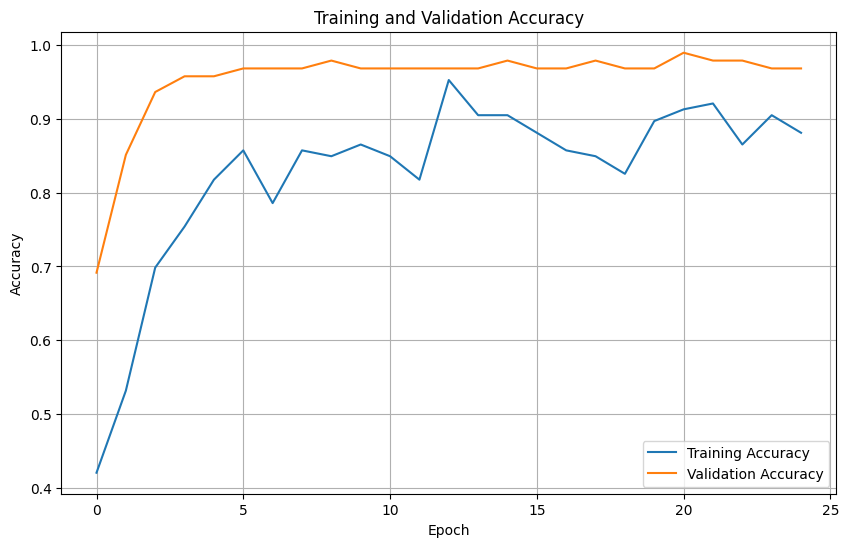

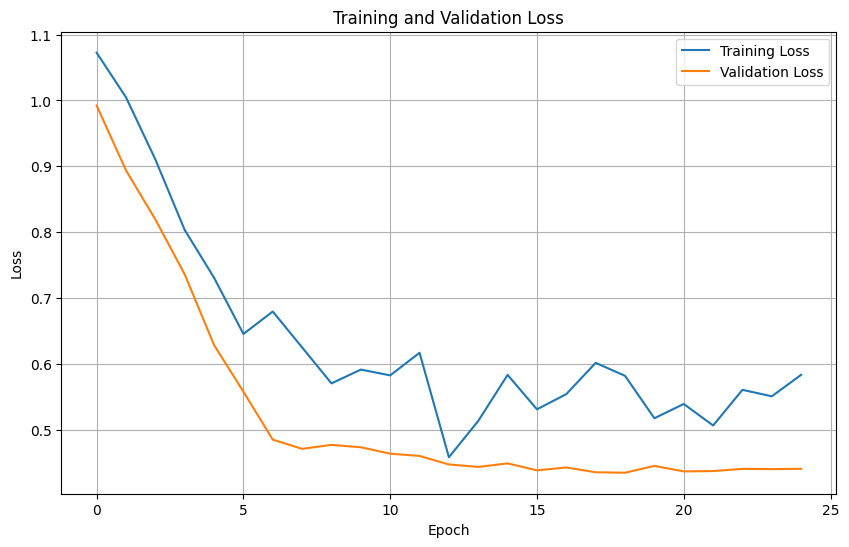

In [60]:
pretrained_model = models.inception_v3(pretrained=True)
pretrained_model.aux_logits=False
#exchange the last layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=25)


Epoch 0/24
----------
train Loss: 1.0767 Acc: 0.3968
val Loss: 1.0005 Acc: 0.6000

Epoch 1/24
----------
train Loss: 1.0680 Acc: 0.4127
val Loss: 0.9734 Acc: 0.7810

Epoch 2/24
----------
train Loss: 0.9635 Acc: 0.6190
val Loss: 0.9316 Acc: 0.7905

Epoch 3/24
----------
train Loss: 0.9484 Acc: 0.6667
val Loss: 0.8974 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.9106 Acc: 0.6667
val Loss: 0.8592 Acc: 0.8762

Epoch 5/24
----------
train Loss: 0.9177 Acc: 0.6587
val Loss: 0.8197 Acc: 0.8952

Epoch 6/24
----------
train Loss: 0.8871 Acc: 0.6667
val Loss: 0.7987 Acc: 0.9429

Epoch 7/24
----------
train Loss: 0.8384 Acc: 0.7460
val Loss: 0.7885 Acc: 0.9429

Epoch 8/24
----------
train Loss: 0.8457 Acc: 0.7778
val Loss: 0.7923 Acc: 0.9524

Epoch 9/24
----------
train Loss: 0.8900 Acc: 0.6905
val Loss: 0.7763 Acc: 0.9619

Epoch 10/24
----------
train Loss: 0.8401 Acc: 0.7460
val Loss: 0.7835 Acc: 0.9333

Epoch 11/24
----------
train Loss: 0.7977 Acc: 0.8254
val Loss: 0.7897 Acc: 0.9238

Ep

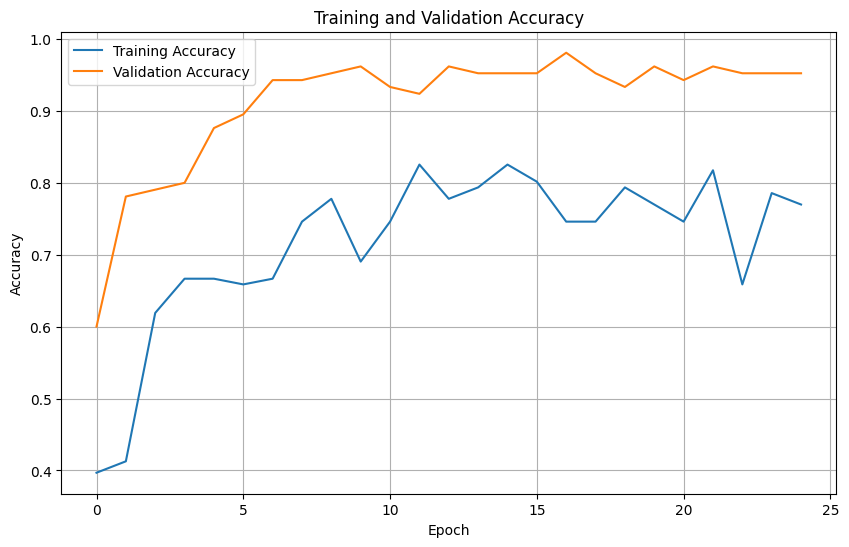

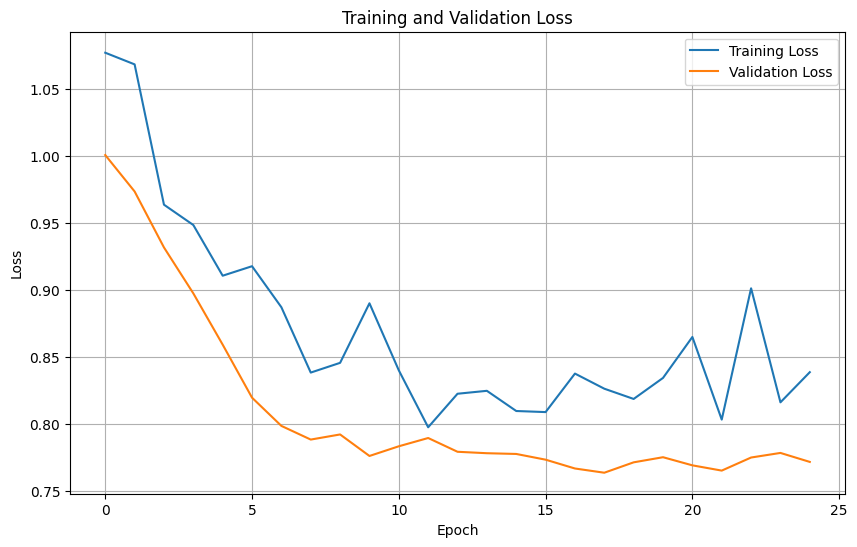

In [69]:
pretrained_model = models.inception_v3(pretrained=True)
pretrained_model.aux_logits=False
for param in pretrained_model.parameters():
    param.requires_grad = False

#exchange the last layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=25)